In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather


100%|██████████| 3.81M/3.81M [00:00<00:00, 227MB/s]

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

for dirname, _, filenames in os.walk('/content/energy-consumption-generation-prices-and-weather'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/energy-consumption-generation-prices-and-weather/weather_features.csv
/content/energy-consumption-generation-prices-and-weather/energy_dataset.csv


In [4]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [5]:
# Read the datasets

df_weather = pd.read_csv(
    '/content/energy-consumption-generation-prices-and-weather/weather_features.csv',
    parse_dates=['dt_iso']
)

df_energy = pd.read_csv(
    '/content/energy-consumption-generation-prices-and-weather/energy_dataset.csv',
    parse_dates=['time']
)

In [6]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [7]:
df_energy.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
generation biomass,35045.000000,383.513540,85.353943,0.000000,0.000000,333.000000,341.000000,367.000000,433.000000,473.000000,592.000000,592.000000
generation fossil brown coal/lignite,35046.000000,448.059208,354.568590,0.000000,0.000000,0.000000,0.000000,509.000000,757.000000,853.000000,999.000000,999.000000
generation fossil coal-derived gas,35046.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
generation fossil gas,35046.000000,5622.737488,2201.830478,0.000000,0.000000,4126.000000,4277.000000,4969.000000,6429.000000,6949.000000,20034.000000,20034.000000
generation fossil hard coal,35046.000000,4256.065742,1961.601013,0.000000,0.000000,2527.000000,2907.000000,4474.000000,5838.750000,6110.000000,8359.000000,8359.000000
generation fossil oil,35045.000000,298.319789,52.520673,0.000000,0.000000,263.000000,273.000000,300.000000,330.000000,338.000000,449.000000,449.000000
generation fossil oil shale,35046.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
generation fossil peat,35046.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
generation geothermal,35046.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
generation hydro pumped storage aggregated,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [8]:
df_weather.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
temp,178396.000000,289.618605,8.026199,262.240000,262.240000,283.670000,284.930000,289.150000,295.150000,296.750000,315.600000,315.600000
temp_min,178396.000000,288.330442,7.955491,262.240000,262.240000,282.483602,283.850000,288.150000,293.730125,295.150000,315.150000,315.150000
temp_max,178396.000000,291.091267,8.612454,262.240000,262.240000,284.650000,286.107000,290.150000,297.150000,298.710000,321.150000,321.150000
pressure,178396.000000,1069.260740,5969.631893,0.000000,0.000000,1013.000000,1014.000000,1018.000000,1022.000000,1023.000000,1008371.000000,1008371.000000
humidity,178396.000000,68.423457,21.902888,0.000000,0.000000,53.000000,57.000000,72.000000,87.000000,88.000000,100.000000,100.000000
wind_speed,178396.000000,2.470560,2.095910,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,4.000000,133.000000,133.000000
wind_deg,178396.000000,166.591190,116.611927,0.000000,0.000000,55.000000,79.000000,177.000000,270.000000,290.000000,360.000000,360.000000
rain_1h,178396.000000,0.075492,0.398847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,12.000000
rain_3h,178396.000000,0.000380,0.007288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.315000,2.315000
snow_3h,178396.000000,0.004763,0.222604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.500000,21.500000


In [9]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [10]:
%%time
missing_data(df_energy)

CPU times: user 22.5 ms, sys: 0 ns, total: 22.5 ms
Wall time: 24.5 ms


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
Total,0,19,18,18,18,18,19,18,18,18,...,19,18,18,0,35064,0,0,36,0,0
Percent,0.0,0.054187,0.051335,0.051335,0.051335,0.051335,0.054187,0.051335,0.051335,0.051335,...,0.054187,0.051335,0.051335,0.0,100.0,0.0,0.0,0.102669,0.0,0.0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [11]:
%%time
missing_data(df_weather)

CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 127 ms


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,object,object,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,object,object,object


In [12]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [13]:
df_energy.describe().round(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,41015.00,101.99,116.80


In [14]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [15]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

In [16]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [17]:
# Find the number of NaNs in each column

df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [18]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series
    created by the user. The user can define either the 'df' and the 'column'
    or the 'series' and additionally, can also define the 'label', the
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

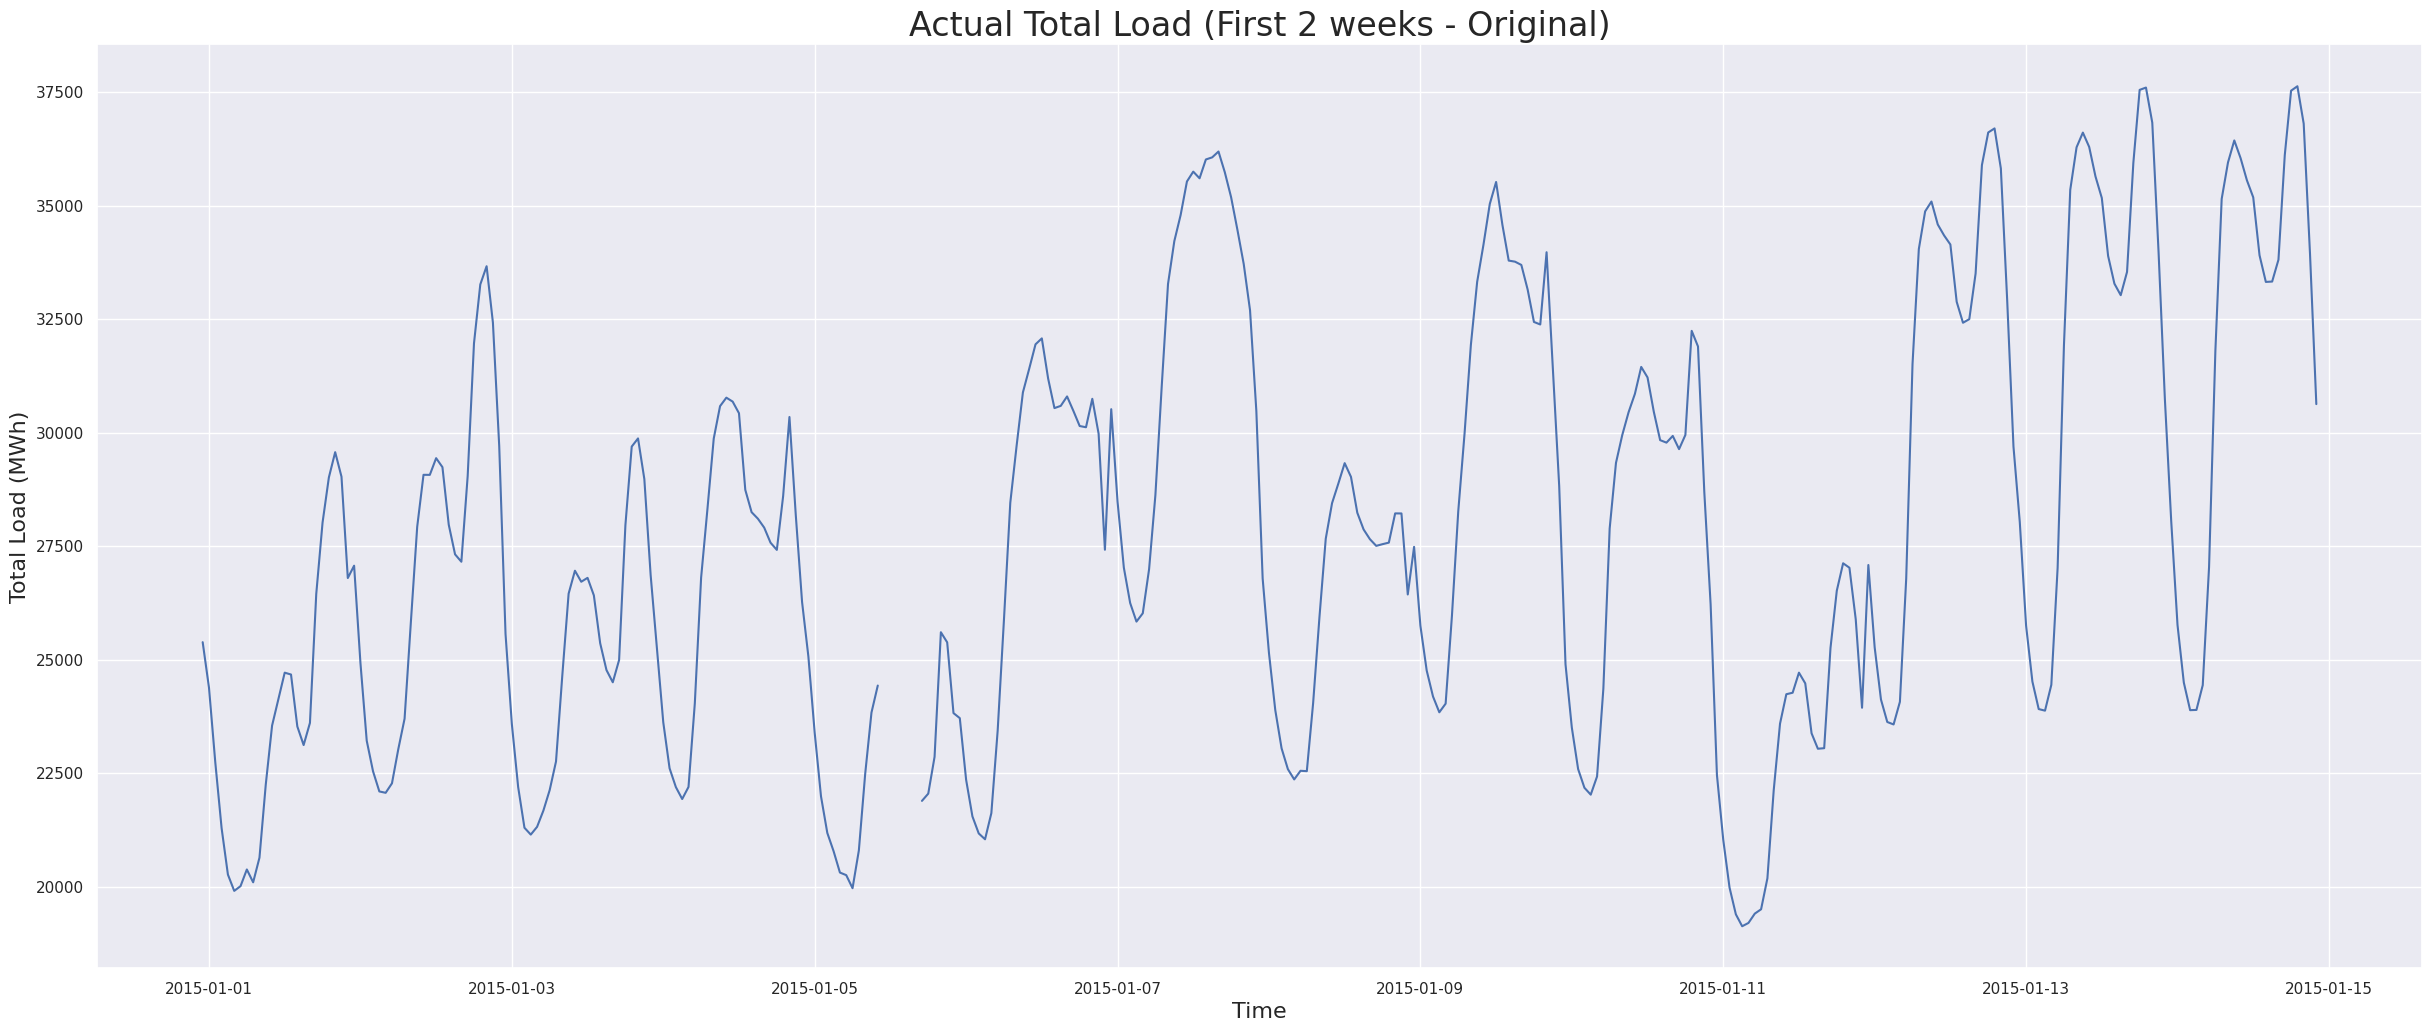

In [19]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [20]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,NaN,69.87,64.93
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.01,69.79


In [21]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [22]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


In [23]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [24]:
df_weather.describe().round(2)

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


In [25]:
# Print the type of each variable in df_weather

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [26]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [27]:
# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [28]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [30]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


In [31]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [32]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [33]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [34]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [35]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [36]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

In [37]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [38]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [39]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [40]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


In [41]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


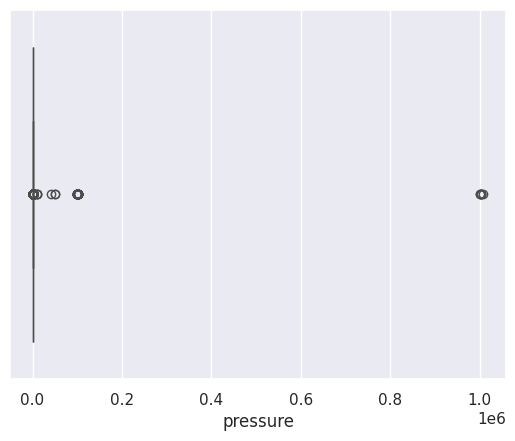

In [42]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [43]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

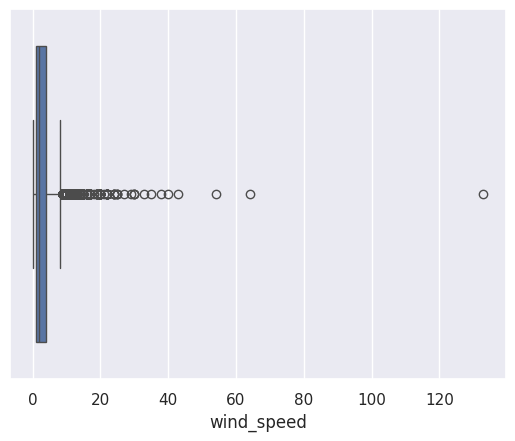

In [45]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [47]:
df_weather.drop_duplicates(subset=['wind_speed'], inplace=True)

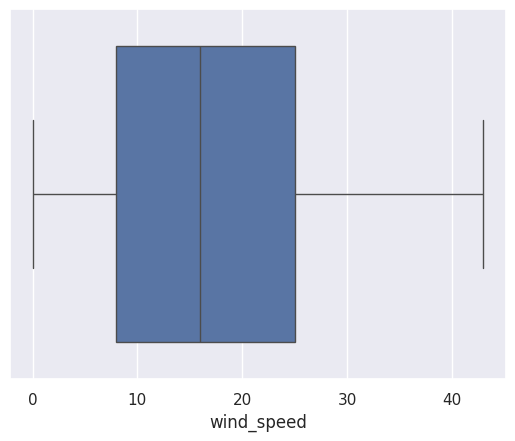

In [48]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan
# Check for outliers in 'wind_speed' column again

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

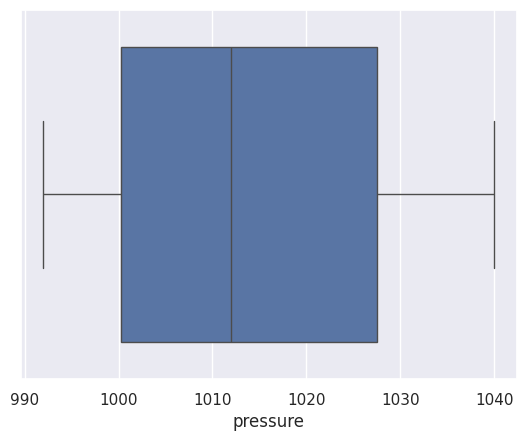

In [49]:
# Check for outliers in 'pressure' column again

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [50]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [56]:
dfs = []
for city_name, city_df in df_weather.groupby('city_name', as_index=False):
    dfs.append(city_df)

In [58]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


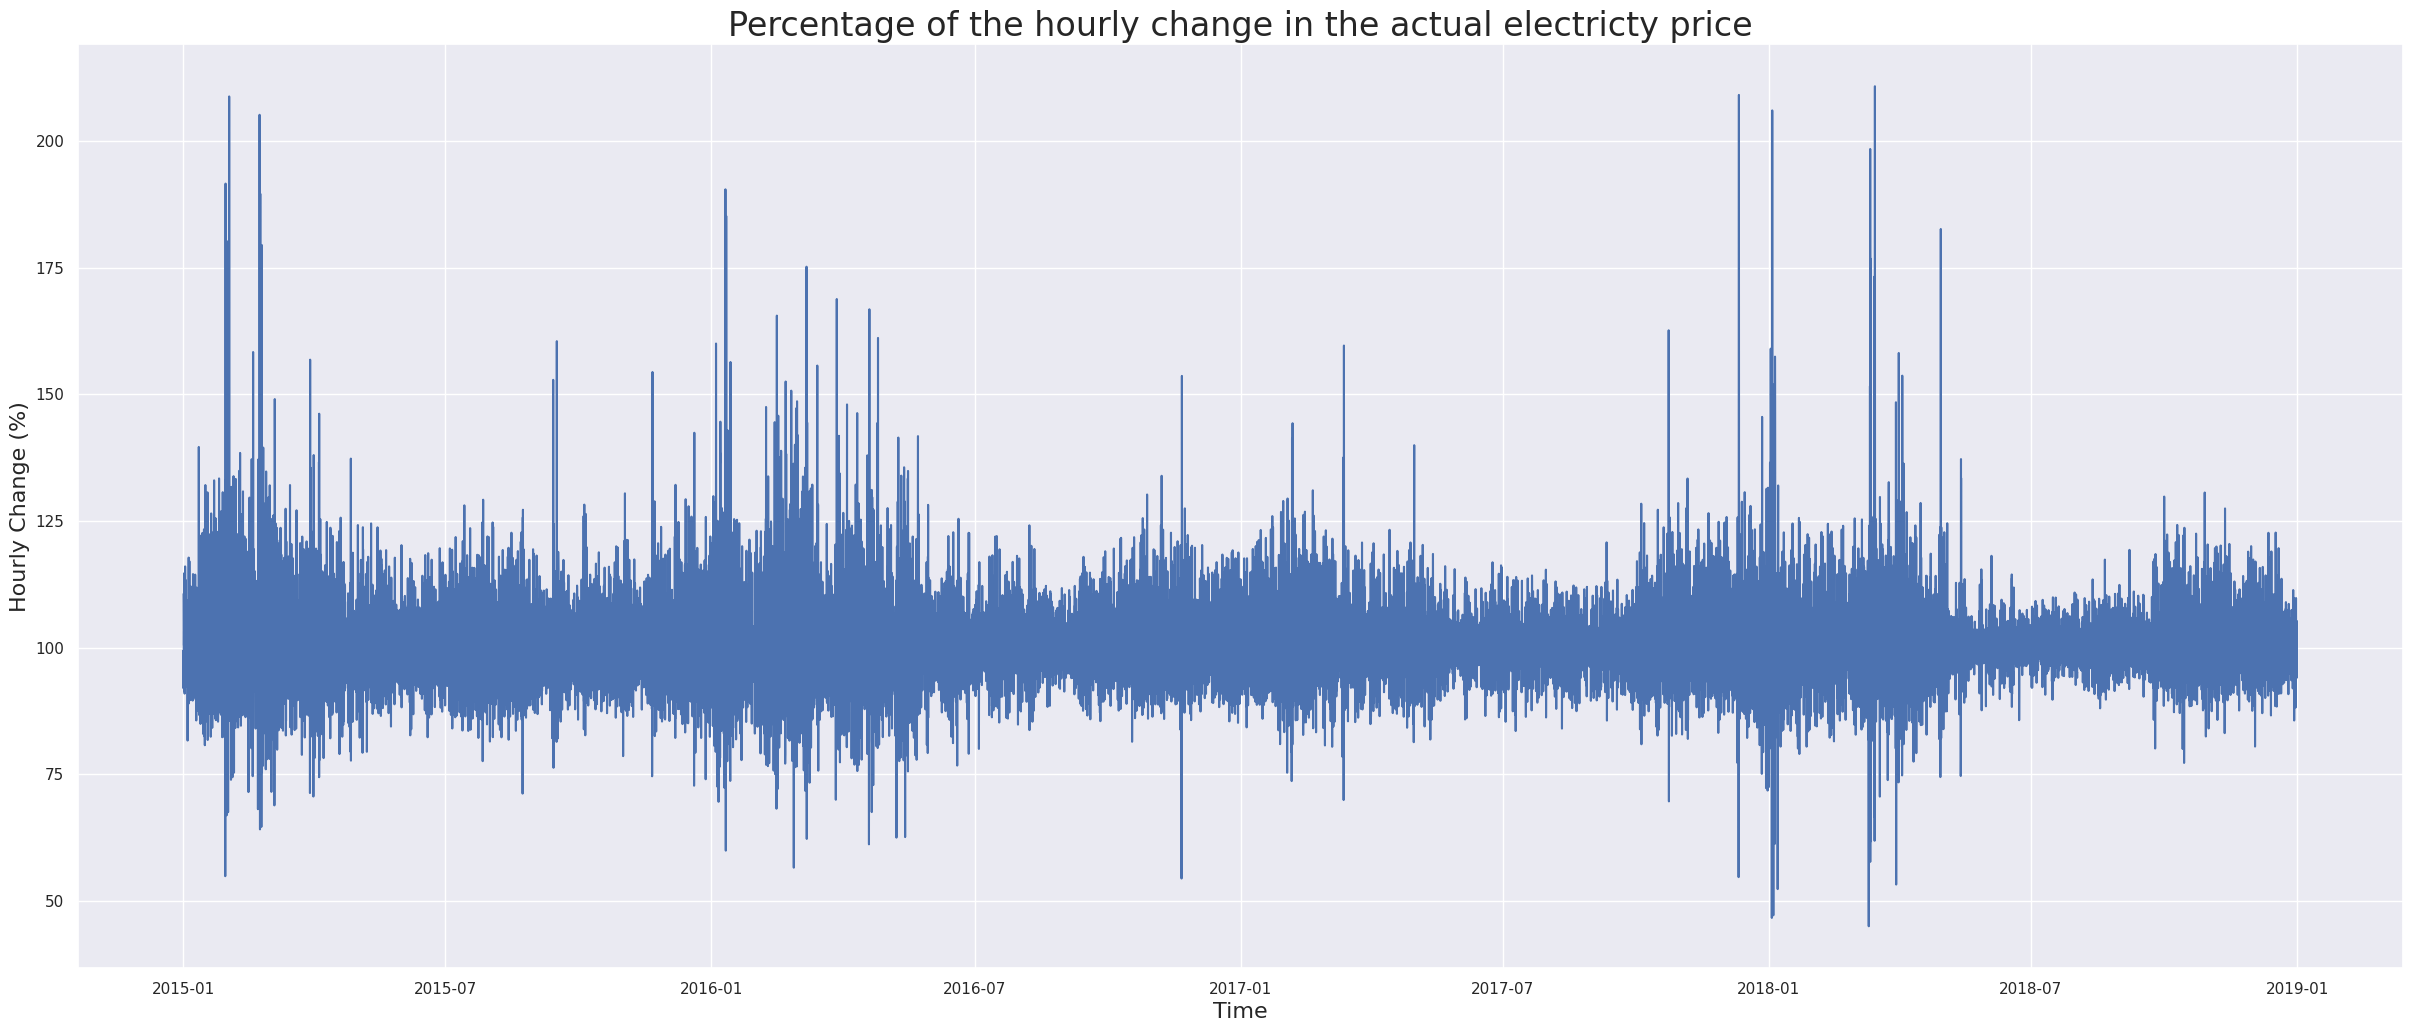

In [61]:
change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

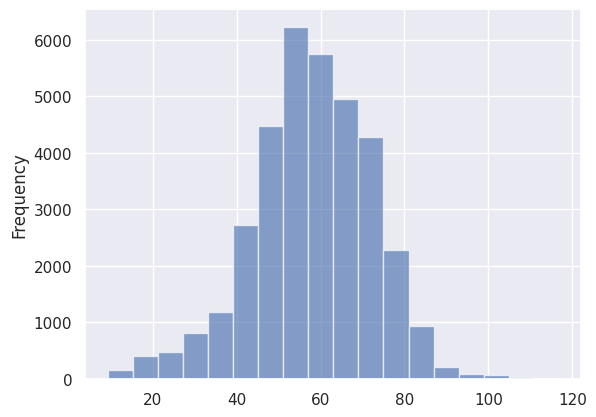

In [62]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

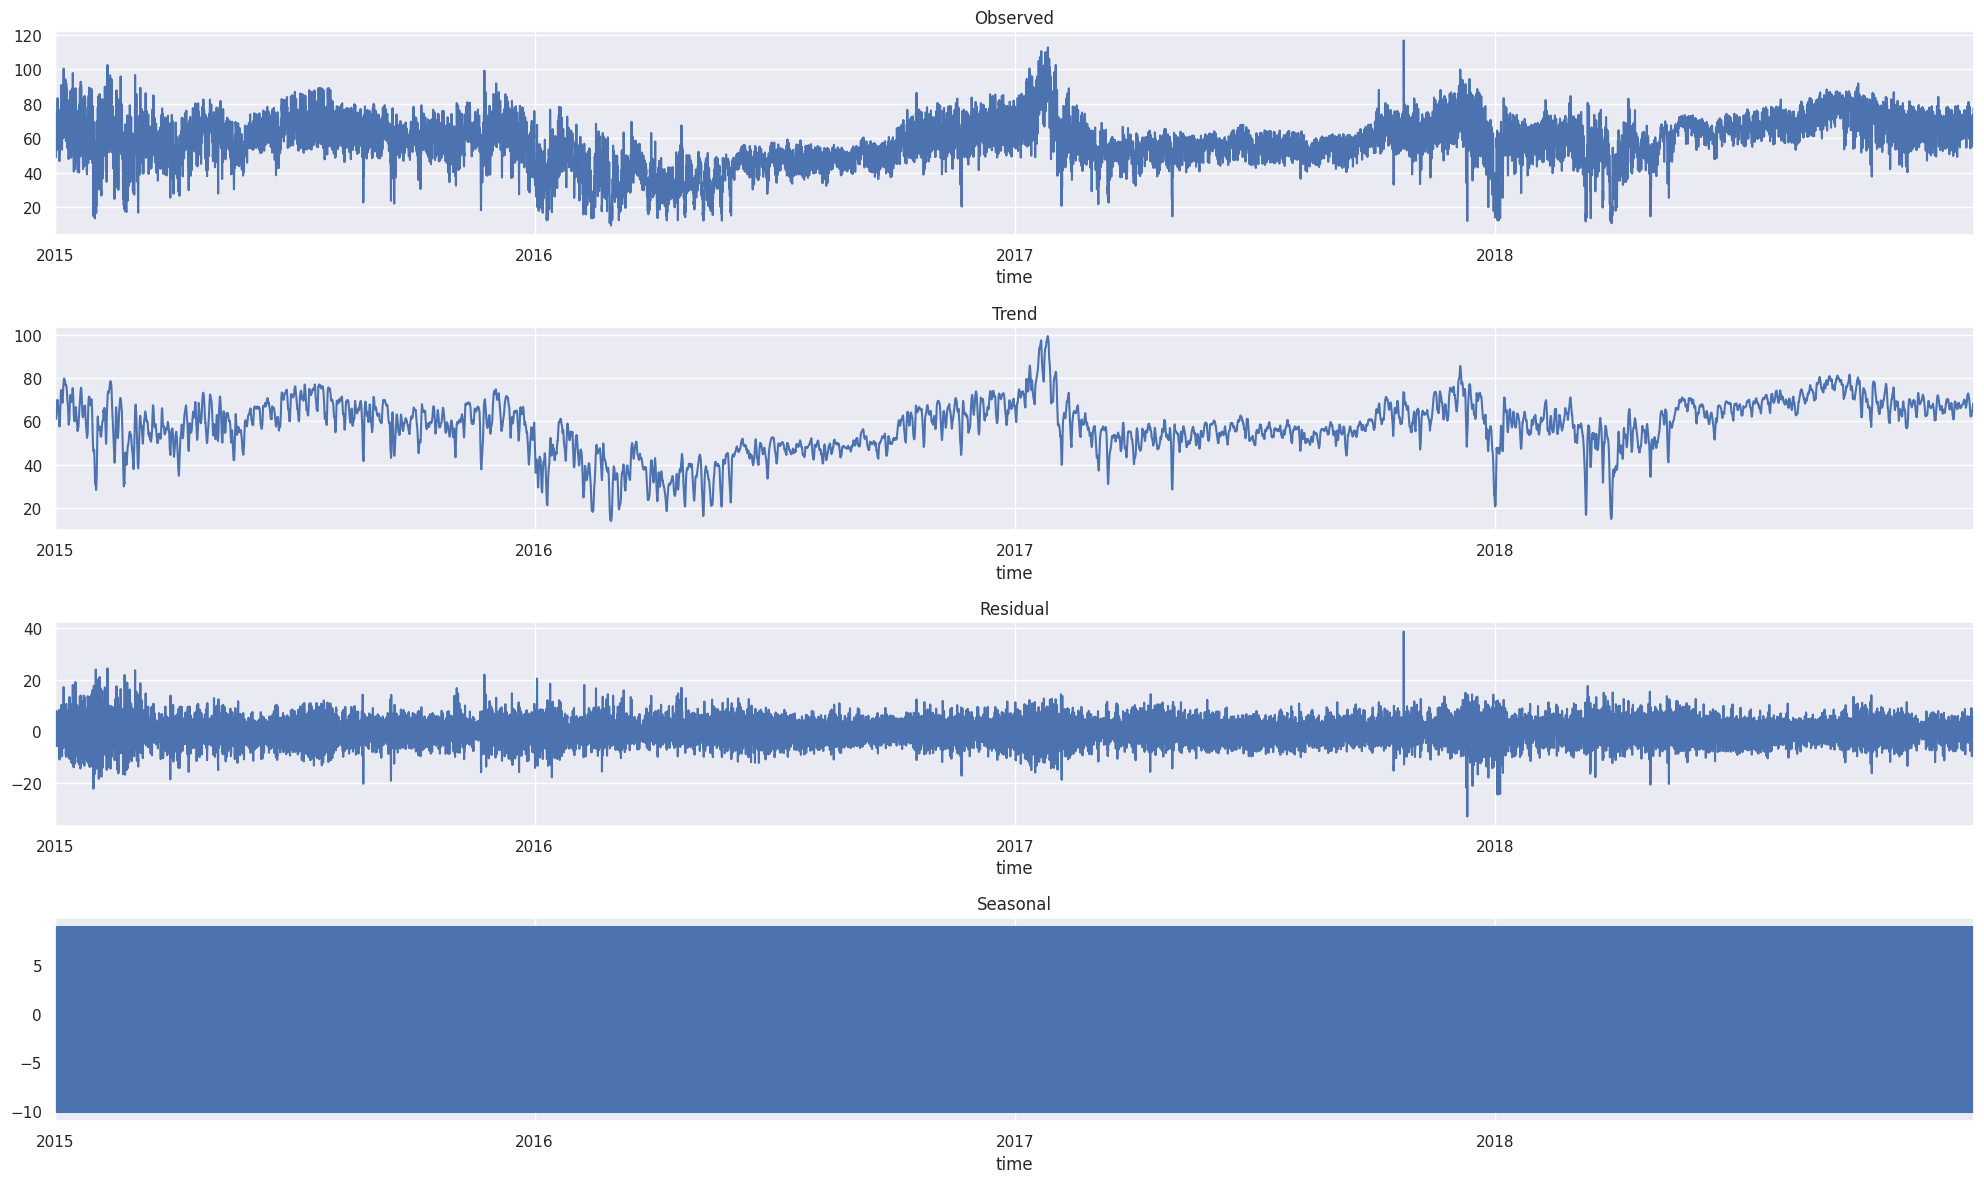

In [63]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()


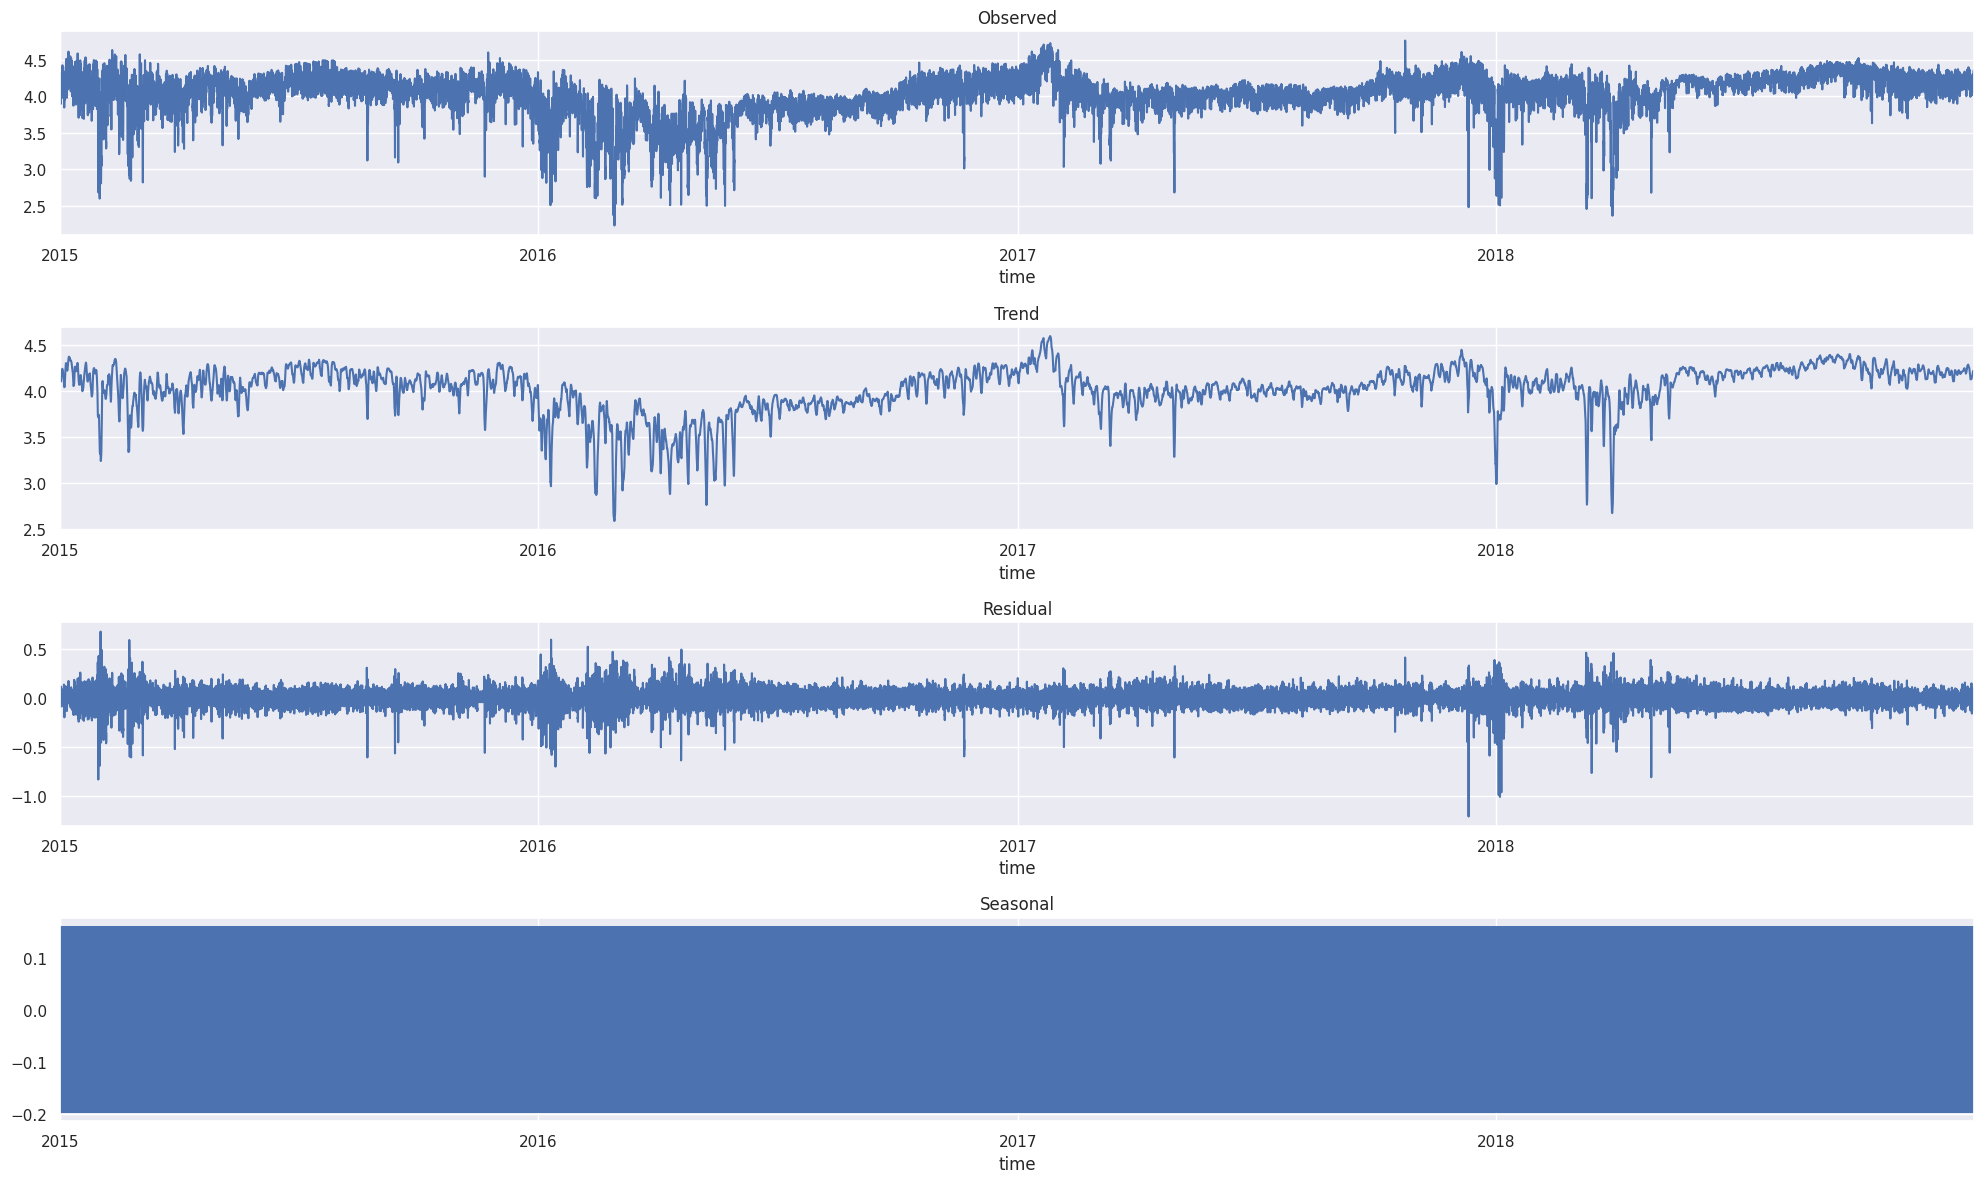

In [64]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [65]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


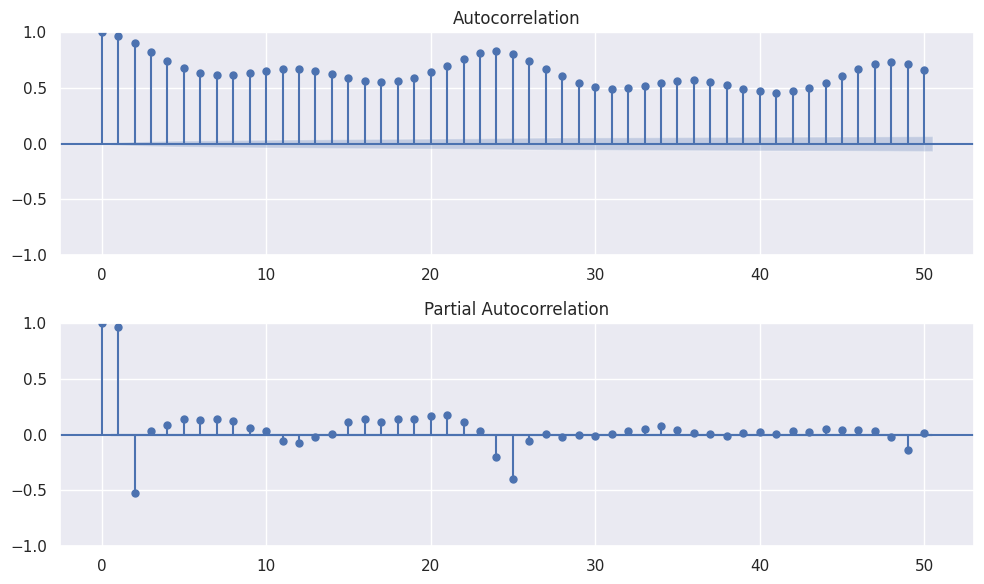

In [67]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

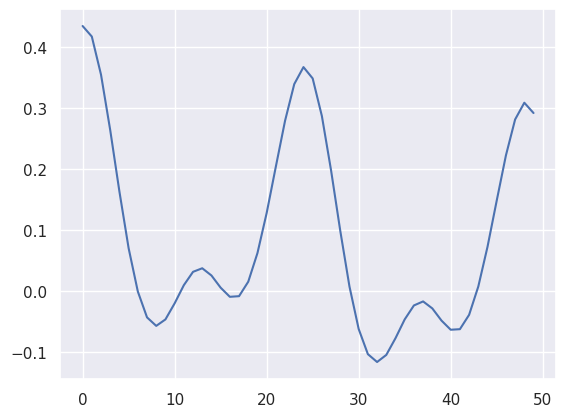

In [68]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

In [69]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
generation waste                               0.168710
generation biomass                             0.142671
generation other                               0.099914
generation solar                               0.098529
generation hydro water reservoir               0.071910
generation nuclear                            -0.053016
generation hydro run-of-river and poundage    -0.136659
generation wind onshore                       -0.220497
generation hydro pumped storage consumption   -0.426196


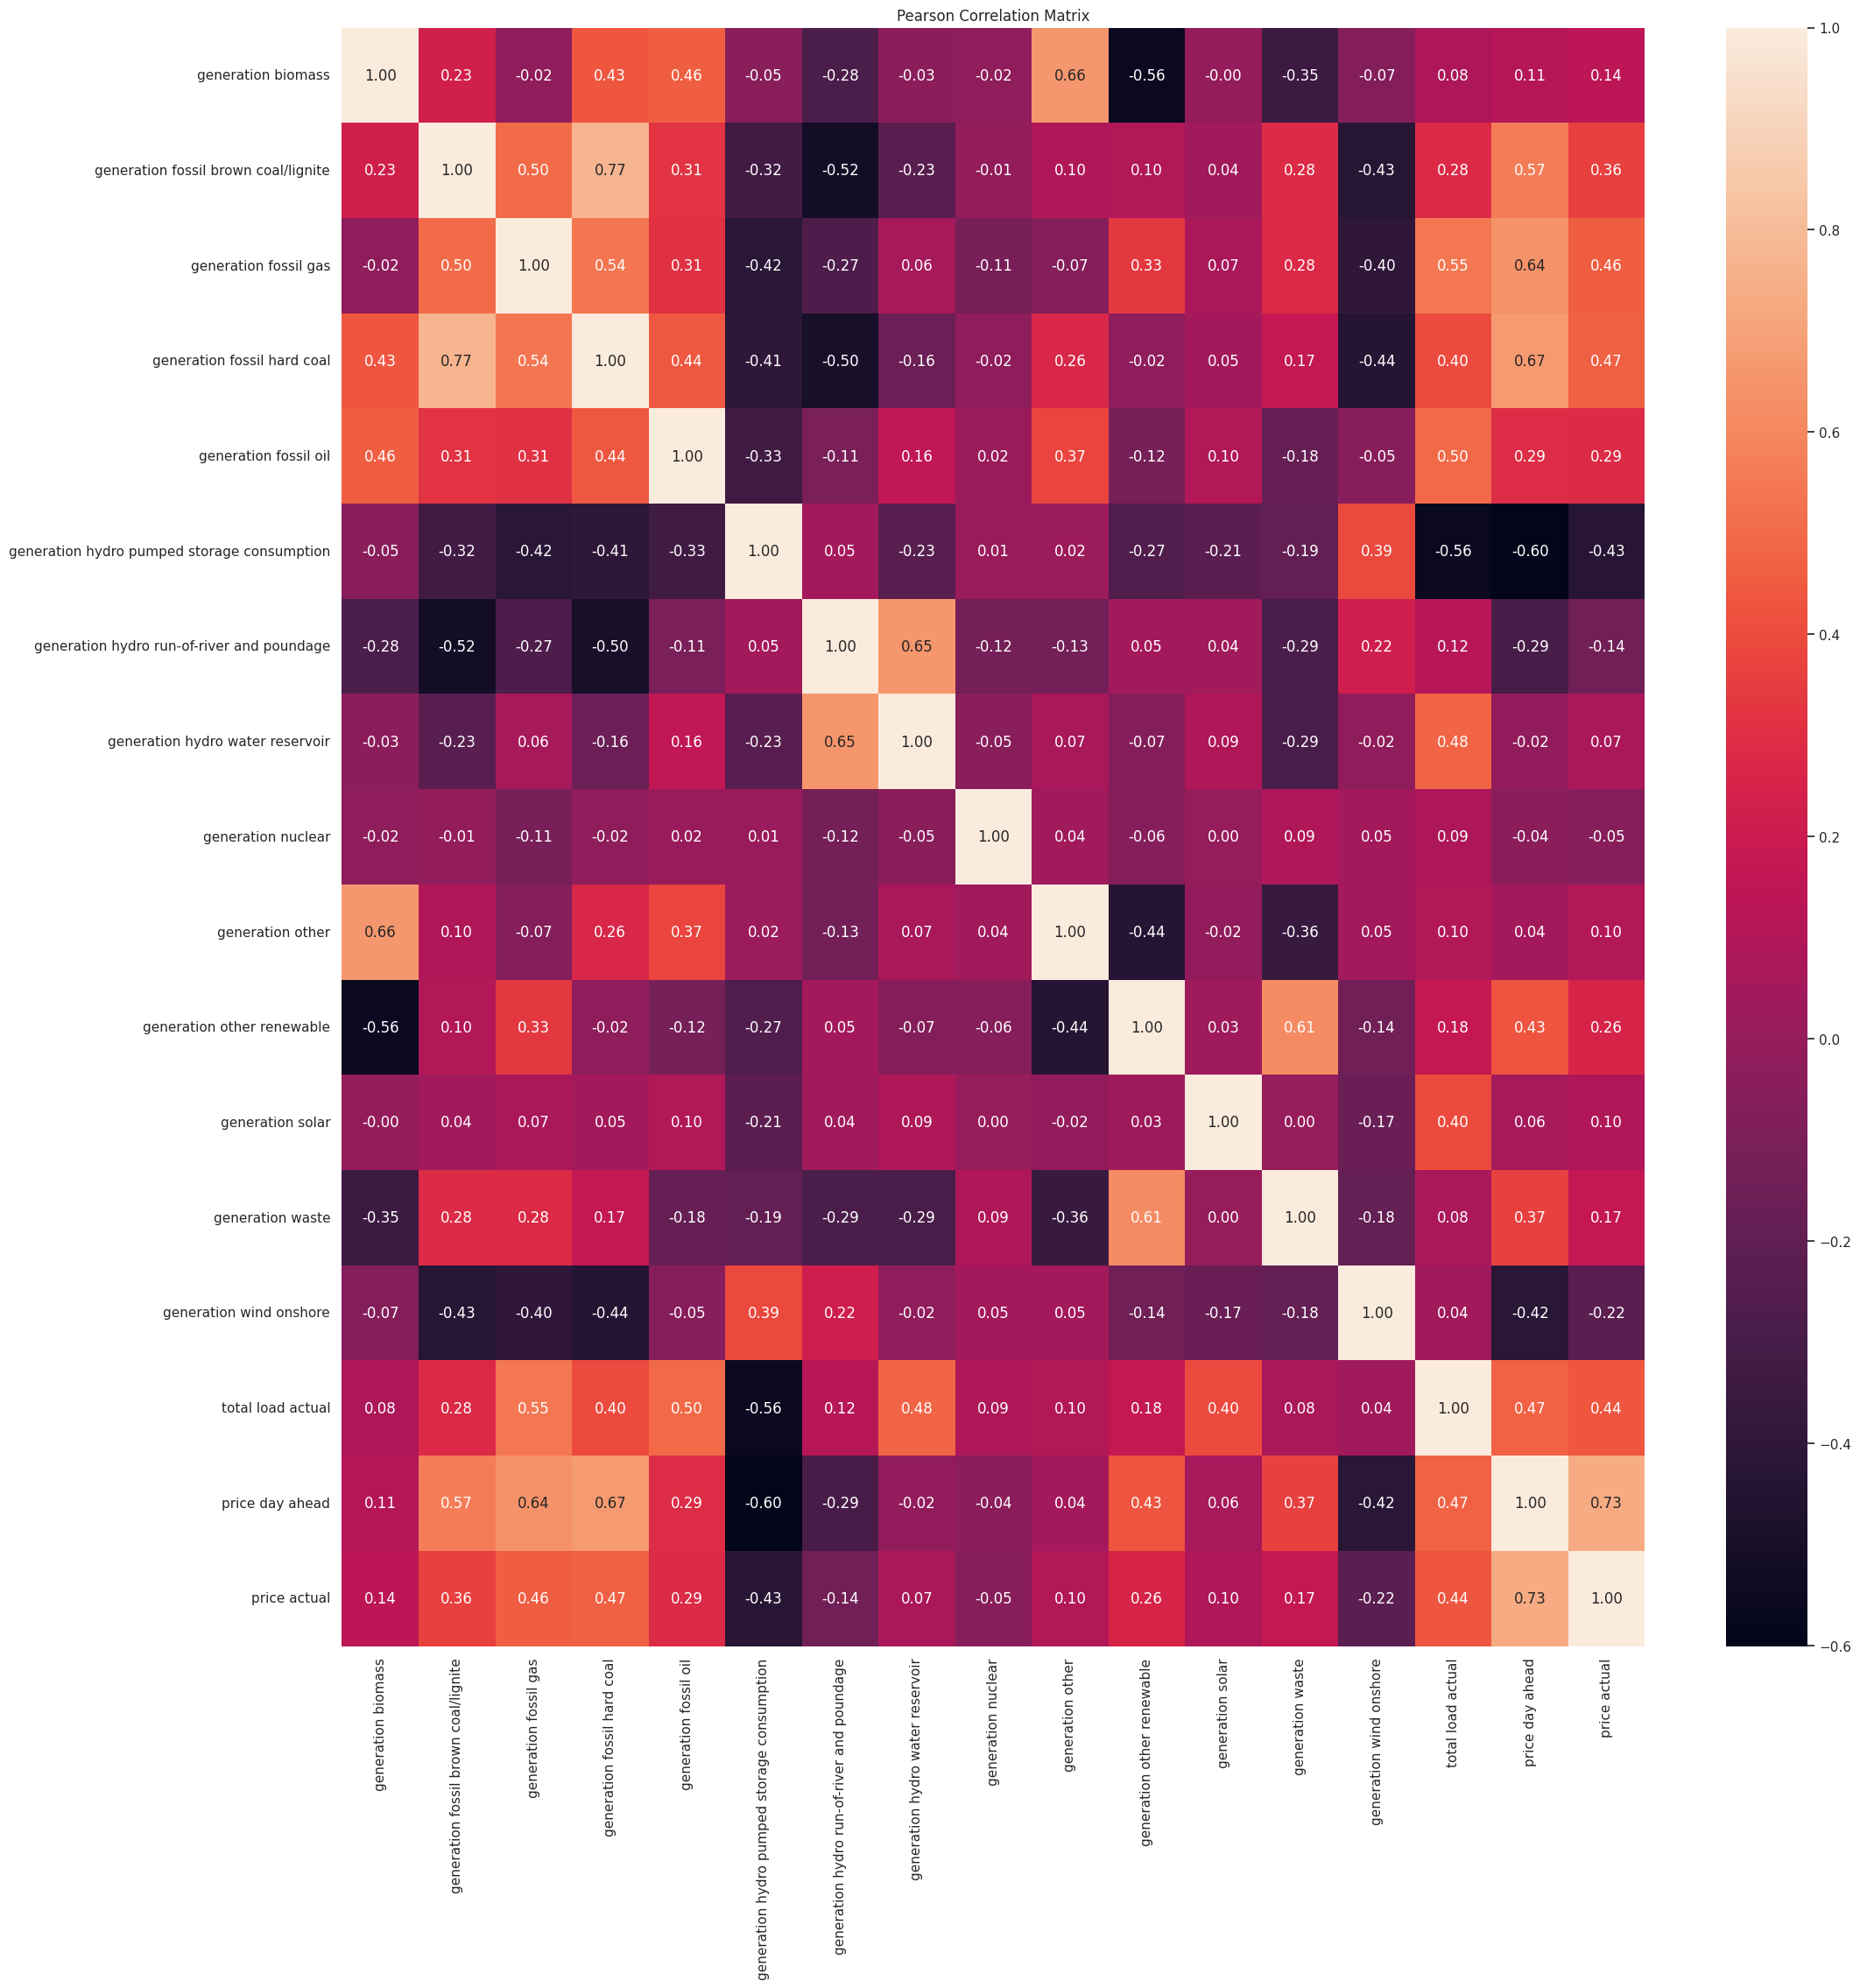

In [71]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [72]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831


In [73]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

In [74]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

In [75]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [77]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [79]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

In [80]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [81]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

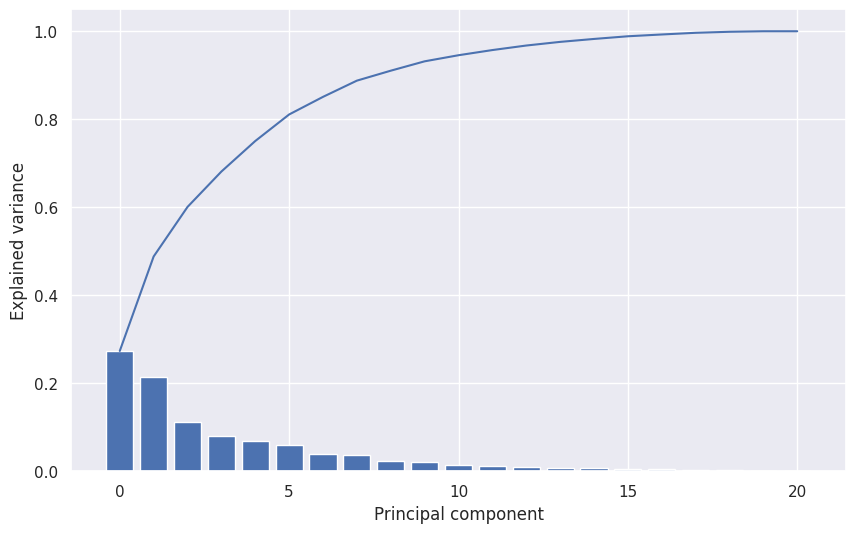

In [82]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [83]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

X_pca.shape

(35064, 6)

In [84]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [85]:
batch_size = 32
buffer_size = 1000
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [86]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [87]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

In [88]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])
param = {'eta': 0.03, 'max_depth': 180,
         'subsample': 1.0, 'colsample_bytree': 0.95,
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse',
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

[0]	train-rmse:0.12945	eval-rmse:0.10906
[1]	train-rmse:0.12580	eval-rmse:0.10597
[2]	train-rmse:0.12227	eval-rmse:0.10303
[3]	train-rmse:0.11885	eval-rmse:0.10012
[4]	train-rmse:0.11553	eval-rmse:0.09733
[5]	train-rmse:0.11233	eval-rmse:0.09463
[6]	train-rmse:0.10922	eval-rmse:0.09201
[7]	train-rmse:0.10620	eval-rmse:0.08949
[8]	train-rmse:0.10329	eval-rmse:0.08707
[9]	train-rmse:0.10047	eval-rmse:0.08469
[10]	train-rmse:0.09774	eval-rmse:0.08239
[11]	train-rmse:0.09510	eval-rmse:0.08019
[12]	train-rmse:0.09254	eval-rmse:0.07807
[13]	train-rmse:0.09006	eval-rmse:0.07599
[14]	train-rmse:0.08766	eval-rmse:0.07401
[15]	train-rmse:0.08535	eval-rmse:0.07209
[16]	train-rmse:0.08310	eval-rmse:0.07021
[17]	train-rmse:0.08093	eval-rmse:0.06842
[18]	train-rmse:0.07884	eval-rmse:0.06672
[19]	train-rmse:0.07681	eval-rmse:0.06506
[20]	train-rmse:0.07485	eval-rmse:0.06346
[21]	train-rmse:0.07296	eval-rmse:0.06191
[22]	train-rmse:0.07113	eval-rmse:0.06043
[23]	train-rmse:0.06936	eval-rmse:0.05902
[2

In [89]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE of hour-ahead electricity price XGBoost forecast: 2.203


In [90]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape,
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [91]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/120
845/845 [==============================] - 14s 7ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 2/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0394
Epoch 3/120
845/845 [==============================] - 5s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 4/120
845/845 [==============================] - 6s 7ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 9.3094e-04 - val_root_mean_squared_error: 0.0305
Epoch 5/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 6/120
845/845 [==============================] - 8s 9ms/step - loss: 9.1298e-04 - root_mean_squared_error: 0.0302 - val_loss

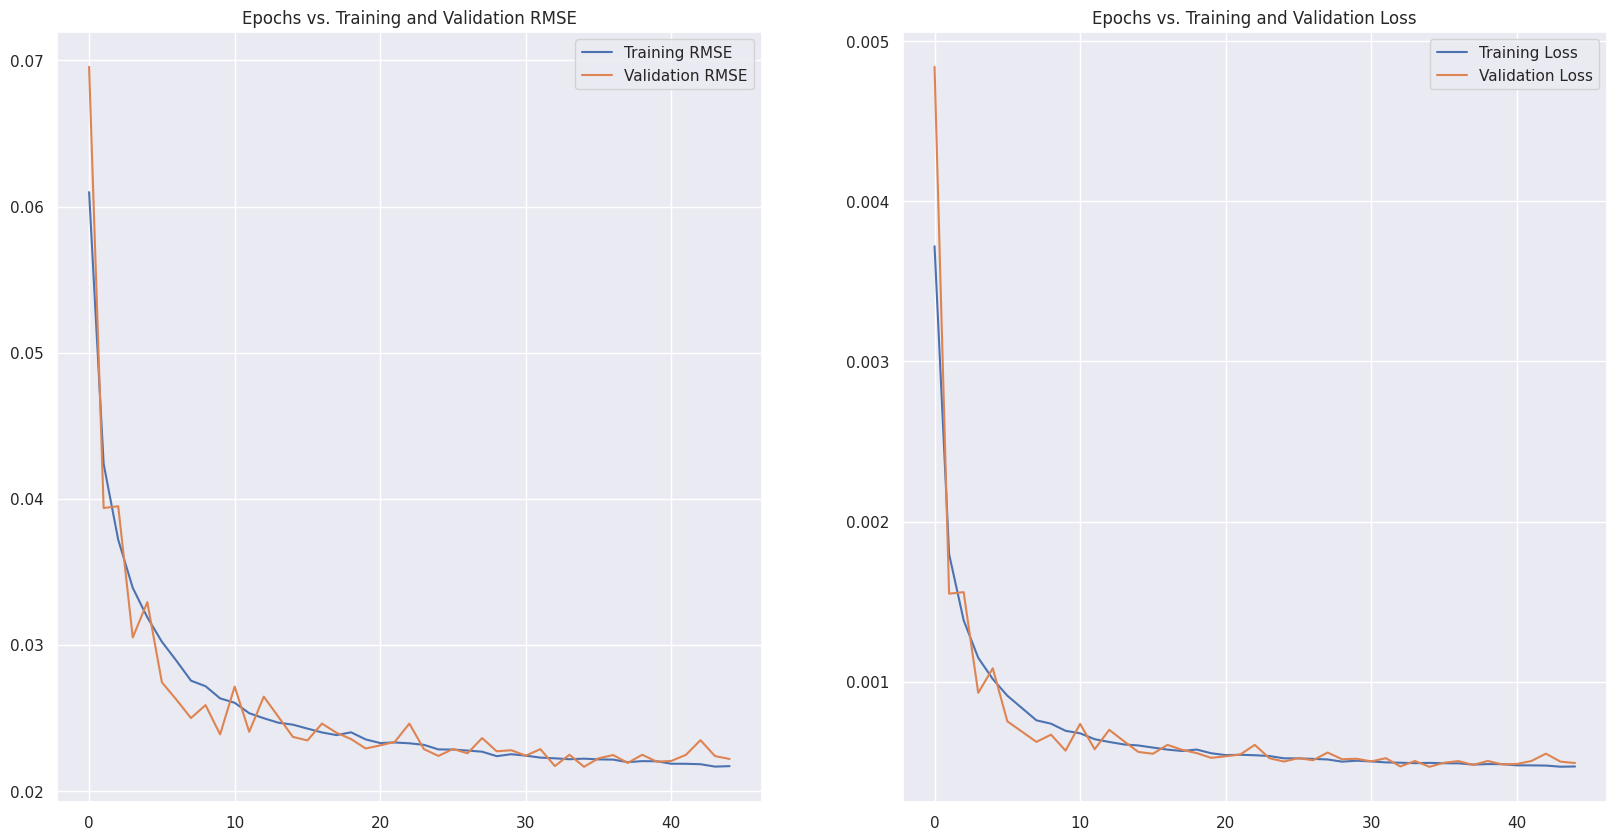

In [93]:
plot_model_rmse_and_loss(history)

In [94]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

125/125 [==============================] - 1s 2ms/step
RMSE of hour-ahead electricity price LSTM forecast: 1.95


In [95]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape,
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [96]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/120
845/845 [==============================] - 12s 9ms/step - loss: 0.0044 - root_mean_squared_error: 0.0625 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 2/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 3/120
845/845 [==============================] - 10s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 4/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 5/120
845/845 [==============================] - 9s 11ms/step - loss: 9.3286e-04 - root_mean_squared_error: 0.0305 - val_loss: 7.1062e-04 - val_root_mean_squared_error: 0.0267
Epoch 6/120
845/845 [==============================] - 9s 10ms/step - loss: 8.0702e-04 - root_mean_squared_error: 0.0284 - 

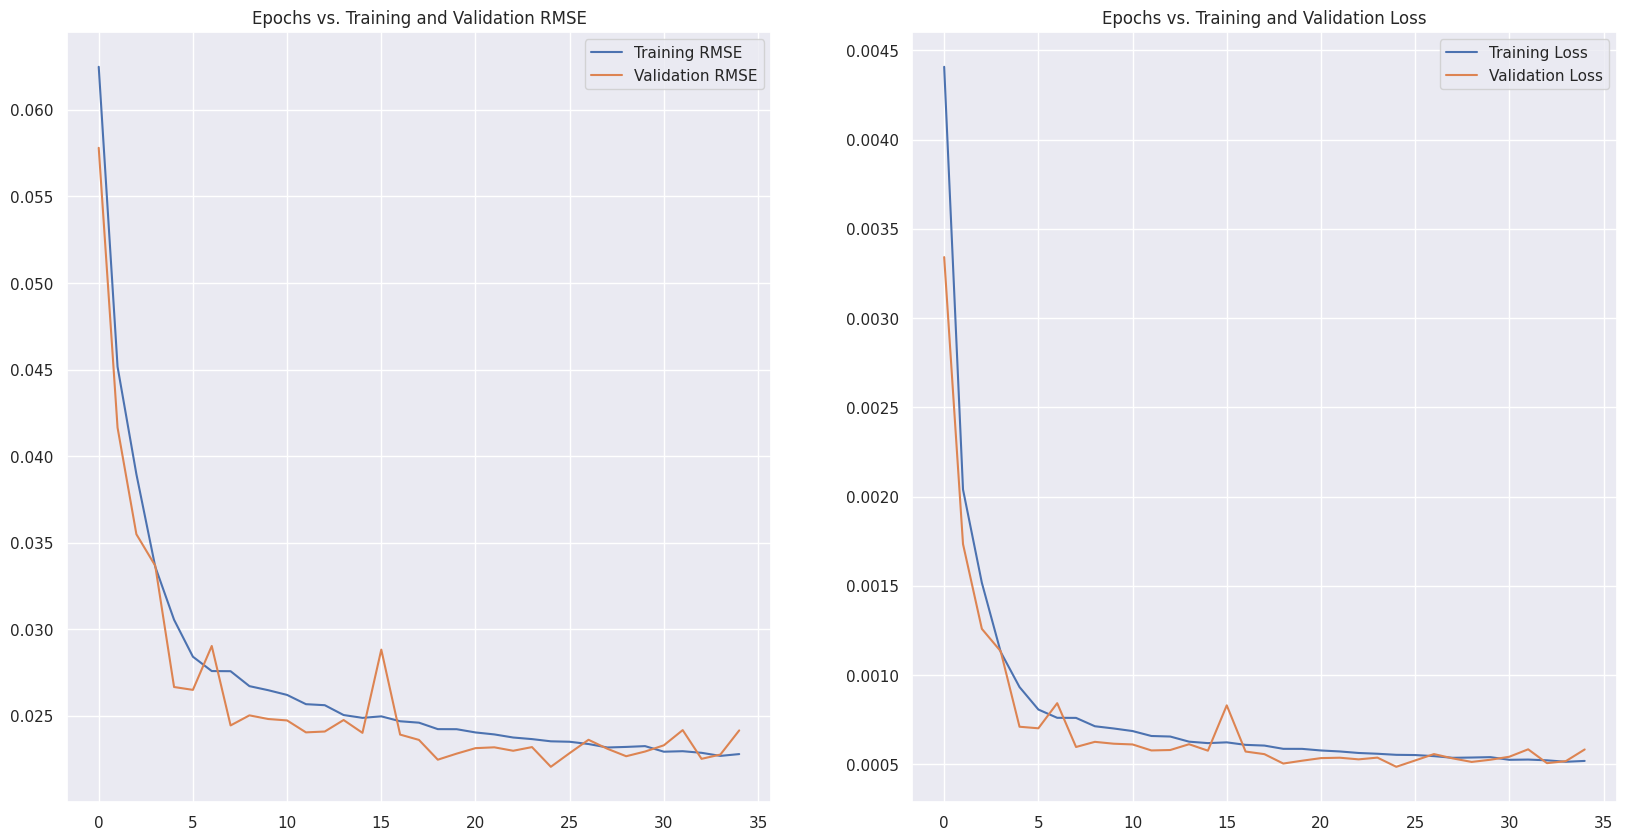

In [97]:
plot_model_rmse_and_loss(history)

In [98]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv,
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))

125/125 [==============================] - 1s 3ms/step
RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 2.105


In [99]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [100]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping,
                                          model_checkpoint])

Epoch 1/120
845/845 [==============================] - 5s 4ms/step - loss: 0.0035 - root_mean_squared_error: 0.0562 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 2/120
845/845 [==============================] - 4s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 3/120
845/845 [==============================] - 3s 4ms/step - loss: 9.9758e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 4/120
845/845 [==============================] - 3s 3ms/step - loss: 8.6601e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 5/120
845/845 [==============================] - 4s 5ms/step - loss: 7.5325e-04 - root_mean_squared_error: 0.0274 - val_loss: 9.5531e-04 - val_root_mean_squared_error: 0.0309
Epoch 6/120
845/845 [==============================] - 4s 5ms/step - loss: 6.8773e-04 - root_mean_squared_error: 0.0262

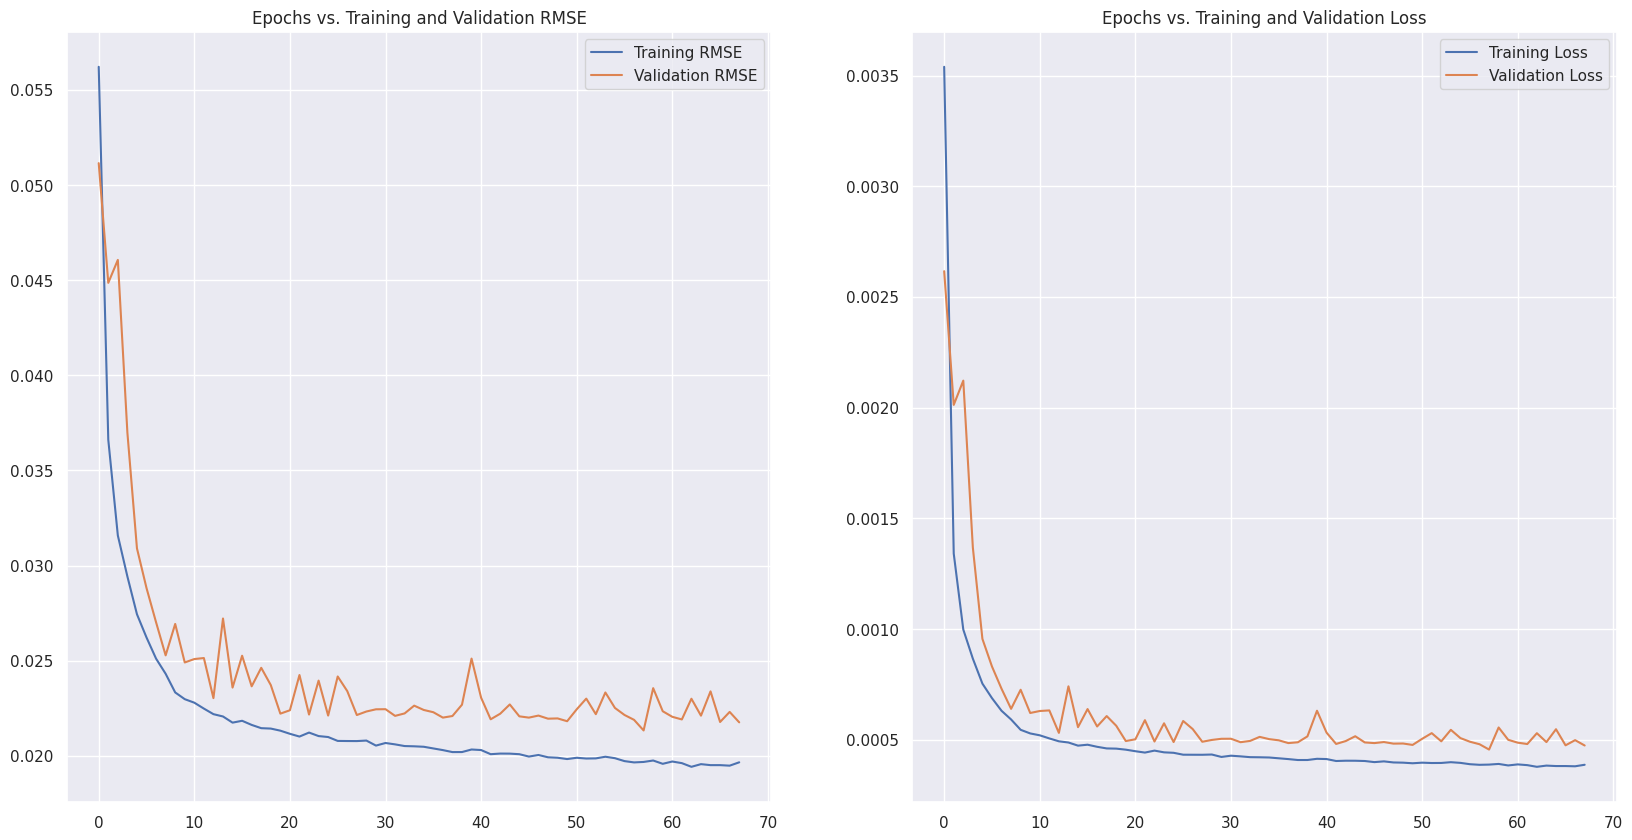

In [101]:
plot_model_rmse_and_loss(history)

In [102]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

125/125 [==============================] - 0s 3ms/step
RMSE of hour-ahead electricity price multivariate CNN forecast: 2.039


In [103]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [104]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping,
                                               model_checkpoint])

Epoch 1/120
845/845 [==============================] - 9s 7ms/step - loss: 0.0031 - root_mean_squared_error: 0.0526 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 2/120
845/845 [==============================] - 6s 7ms/step - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 3/120
845/845 [==============================] - 5s 6ms/step - loss: 9.1042e-04 - root_mean_squared_error: 0.0302 - val_loss: 9.0169e-04 - val_root_mean_squared_error: 0.0300
Epoch 4/120
845/845 [==============================] - 5s 6ms/step - loss: 7.0935e-04 - root_mean_squared_error: 0.0266 - val_loss: 7.4620e-04 - val_root_mean_squared_error: 0.0273
Epoch 5/120
845/845 [==============================] - 7s 8ms/step - loss: 6.0586e-04 - root_mean_squared_error: 0.0246 - val_loss: 6.4153e-04 - val_root_mean_squared_error: 0.0253
Epoch 6/120
845/845 [==============================] - 5s 6ms/step - loss: 5.4721e-04 - root_mean_squared_error

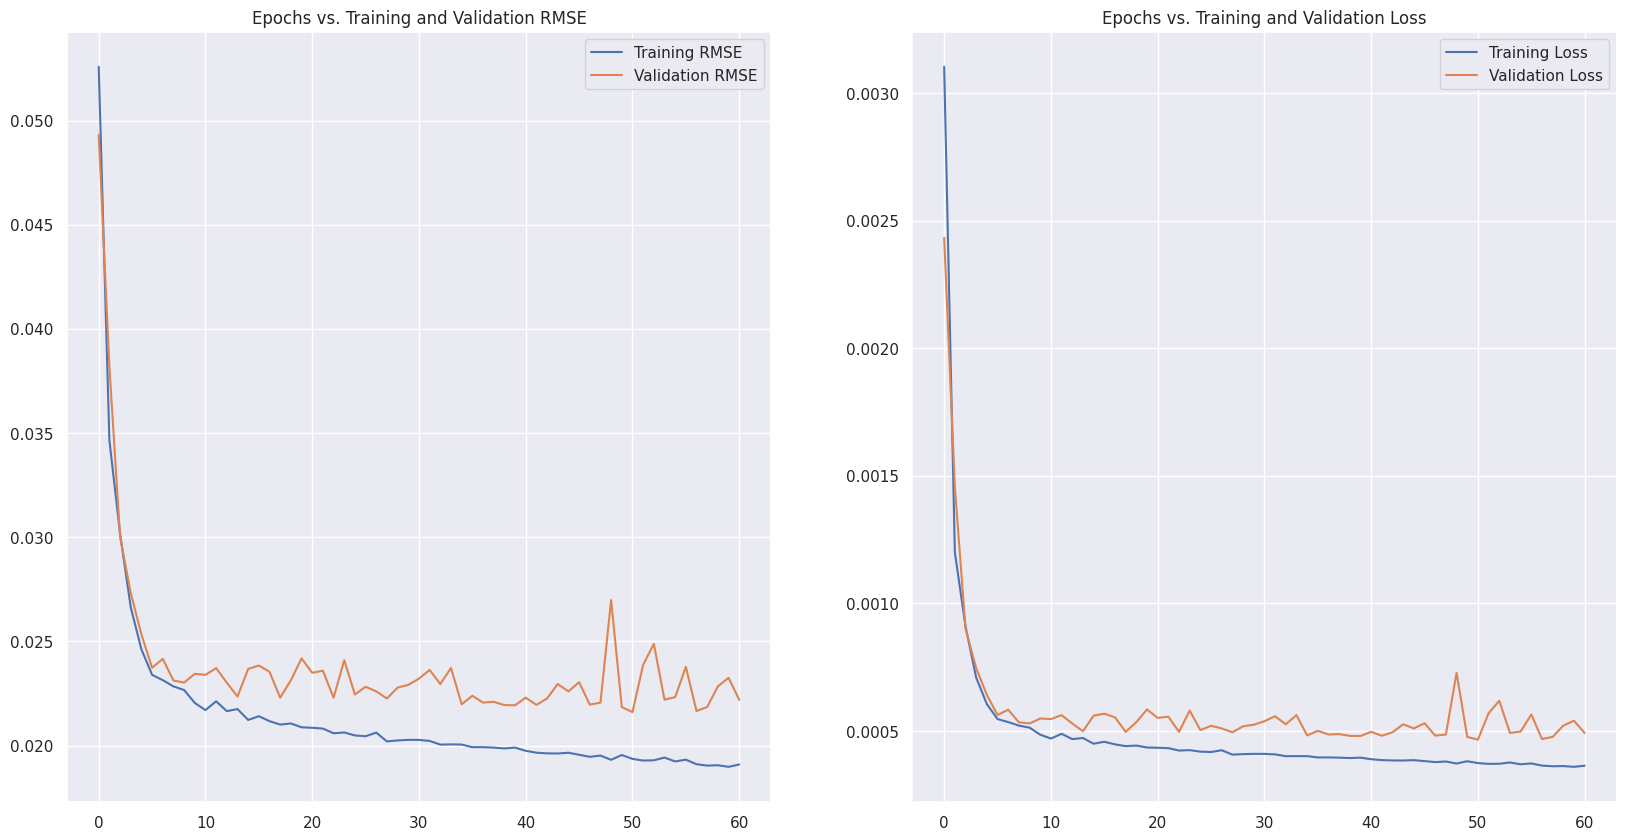

In [105]:
plot_model_rmse_and_loss(history)

In [106]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv,
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

125/125 [==============================] - 1s 2ms/step
RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: 2.06


In [107]:
X_test.shape

(3984, 24, 7)

In [108]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [109]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping,
                                          model_checkpoint])

Epoch 1/120
845/845 [==============================] - 7s 6ms/step - loss: 0.0033 - root_mean_squared_error: 0.0542 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 2/120
845/845 [==============================] - 4s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 8.4942e-04 - val_root_mean_squared_error: 0.0291
Epoch 3/120
845/845 [==============================] - 4s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 7.2835e-04 - val_root_mean_squared_error: 0.0270
Epoch 4/120
845/845 [==============================] - 5s 6ms/step - loss: 9.1737e-04 - root_mean_squared_error: 0.0303 - val_loss: 6.3068e-04 - val_root_mean_squared_error: 0.0251
Epoch 5/120
845/845 [==============================] - 4s 5ms/step - loss: 9.0635e-04 - root_mean_squared_error: 0.0301 - val_loss: 6.4175e-04 - val_root_mean_squared_error: 0.0253
Epoch 6/120
845/845 [==============================] - 4s 4ms/step - loss: 7.9873e-04 - root_mean_squared_error

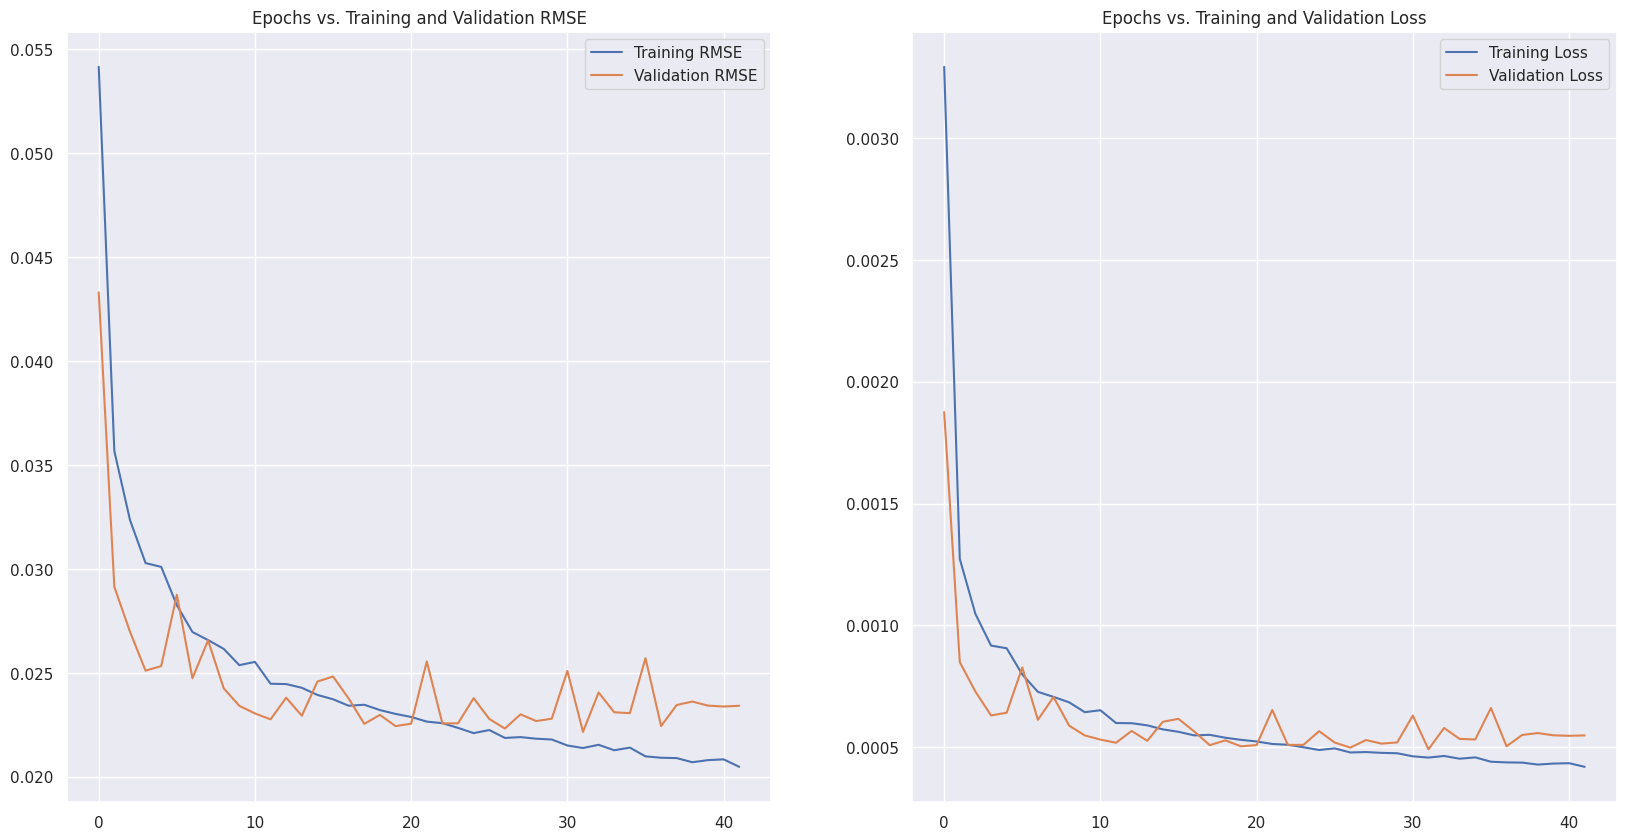

In [110]:
plot_model_rmse_and_loss(history)

In [111]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

125/125 [==============================] - 0s 2ms/step
RMSE of hour-ahead electricity price multivariate MLP forecast: 2.165


In [112]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [113]:
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping,
                                         model_checkpoint])

Epoch 1/50
845/845 [==============================] - 65s 73ms/step - loss: 0.0044 - root_mean_squared_error: 0.0624 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 2/50
845/845 [==============================] - 59s 69ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 3/50
845/845 [==============================] - 59s 70ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 4/50
845/845 [==============================] - 58s 69ms/step - loss: 8.5896e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 5/50
845/845 [==============================] - 60s 71ms/step - loss: 7.3622e-04 - root_mean_squared_error: 0.0271 - val_loss: 7.8893e-04 - val_root_mean_squared_error: 0.0281
Epoch 6/50
845/845 [==============================] - 58s 69ms/step - loss: 7.0861e-04 - root_mean_squared_error: 0.02

In [ ]:
plot_model_rmse_and_loss(history)

In [116]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv,
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

125/125 [==============================] - 2s 13ms/step
RMSE of hour-ahead electricity price Encoder-Decoder forecast: 2.16
